
## Ideas

- symantic web technology, micro applications (combine the approaches)
- the role of authors, citations
- sensitivity 1 doesn't work. (multiple raters, different expertise)
- citation networks
- use of rules how to interpreted the text. 


## Remarks

- Covidence and Rayyan (software)
- 



# Systematic review

Based on: https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py

> This script loads pre-trained word embeddings (GloVe embeddings)
into a frozen Keras Embedding layer, and uses it to
train a text classification model on the 20 Newsgroup dataset
(classification of newsgroup messages into 20 different categories).
GloVe embedding data can be found at:
http://nlp.stanford.edu/data/glove.6B.zip
(source page: http://nlp.stanford.edu/projects/glove/)
20 Newsgroup data can be found at:
http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.html


## Related links
https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/
https://machinelearningmastery.com/best-practices-document-classification-deep-learning/
https://www.quora.com/What-deep-learning-method-to-use-to-classify-text-files

Import dependencies

In [2]:
%matplotlib inline

In [3]:
from __future__ import print_function

import os
import sys
import numpy as np
import pandas as pd
import sklearn
import keras_metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras import metrics
from keras.callbacks import TensorBoard

from nltk.corpus import stopwords
from prettytable import PrettyTable
from numpy import cumsum
from matplotlib import pyplot
from pandas import DataFrame
from datetime import datetime
from scipy import stats
from keras.layers import Bidirectional

Using TensorFlow backend.


## Project properties

Basic output properties related to the folder structure.

In [4]:
# OUTPUT_DIR = os.path.join("..", "output")

LOG_DIR = os.path.join("..","logs")

## Evaluation Criteria

- minimize number of papers
- max # of fn =1
- threshhold >0

## Data

Basic data related variables.

In [5]:
# the data folder
BASE_DIR = os.path.join("..", "data")

# the folder with the word2vec 
GLOVE_DIR = os.path.join("..", "word2vec")

# the papers about PTSD
TEXT_DATA_DIR = os.path.join(BASE_DIR, "ptsd_review", "csv")

# the target variable
TARGET_VARIABLE = "included_final" # "included_ats" (after title screening)


Read data in memory.

In [6]:
# second, prepare text samples and their labels
print('Processing text dataset')

data_path = os.path.join(TEXT_DATA_DIR, "schoot-lgmm-ptsd-traindata.csv")
full_data = pd.read_csv(data_path)

texts = (full_data['title'].fillna('') + ' ' + full_data['abstract'].fillna(''))
labels = full_data[TARGET_VARIABLE]
print('Found %s texts.' % len(texts))

Processing text dataset
Found 5077 texts.


## Word tokenizing

Apply vectorization to texts.

In [7]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000

In [8]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# get the word index
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, 
                     maxlen=MAX_SEQUENCE_LENGTH, 
                     padding='post', truncating='post')
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 26396 unique tokens.
Shape of data tensor: (5077, 1000)
Shape of label tensor: (5077, 2)


## Create training and validation set
Split the dataset into a training and a validation set. Use SciKit-learn for this. 
We decided to train our model on a small dataset (around 500), to make the environment more simulated to the active learning approach where we have small number of labeled data points. 

In [181]:
from sklearn.model_selection import train_test_split

def split_data(validation_split, added_positives):
    x_train, x_val, y_train, y_val = train_test_split(
        data,
        labels,
        test_size=validation_split,
        random_state=2018,
        stratify=labels
    )

    # add added_positives positive paper to training dataset
    if added_positives>0 :
        positive_indx = np.where(y_val[:,1]==1)[0]
        x_train = np.vstack((x_train, x_val[positive_indx[0:added_positives]]))
        y_train = np.vstack((y_train,y_val[positive_indx[0:added_positives]]))

        x_val = np.delete(x_val, positive_indx[0:added_positives],0)
        y_val = np.delete(y_val, positive_indx[0:added_positives],0)

    return (x_train, x_val, y_train, y_val)

x_train, x_val, y_train, y_val = split_data(0.2, 0)

print("x_train shape:", x_train.shape, ", x_val shape:", x_val.shape)
print("y_train shape:", y_train.shape, ", y_val shape:", y_val.shape)
print("included papers in train dataset:",(y_train[:,1]==1).sum())
print("included papers in test dataset:",(y_val[:,1]==1).sum())


x_train shape: (4061, 1000) , x_val shape: (1016, 1000)
y_train shape: (4061, 2) , y_val shape: (1016, 2)
included papers in train dataset: 32
included papers in test dataset: 8


## Prepare embedding layer


In [10]:
## set dimensions
EMBEDDING_DIM = 300

In [11]:
# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'wiki.en.vec'), encoding='utf8') as f:
    for line in f:
        
        values = line.split()
        split_on_i = len(values) - EMBEDDING_DIM
        word = ' '.join(values[0:split_on_i])
        coefs = np.asarray(values[split_on_i:], dtype='float32')
        embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 2518927 word vectors.


In [12]:
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
            continue
        
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
                
print('Shape of embedding matrix: ', embedding_matrix.shape)

Shape of embedding matrix:  (20000, 300)


## Make an Keras embedding layer.

In [13]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
def build_embedding(weights):
    return Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[weights],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)

embedding_layer = build_embedding(embedding_matrix)

## Models

This section contains models to use later on. Focusing on Convolutional and LSTM models. 

### LSTM

In [14]:
def get_lstm_model(backwards, dropout, neurons,optimizer ):
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    x = LSTM(neurons,input_shape=(MAX_SEQUENCE_LENGTH,),  go_backwards=backwards, dropout=dropout)(embedded_sequences)
    x = Dense(128,activation='relu')(x)
    output = Dense(2, activation='softmax')(x)

    model_lstm = Model(inputs=sequence_input, outputs=output)

    model_lstm.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc',keras_metrics.recall()])

    model_lstm.summary()
    return model_lstm

def get_bi_lstm_model(mode, dropout, neurons, optimizer):
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    x = Bidirectional(LSTM(neurons,input_shape=(MAX_SEQUENCE_LENGTH,), dropout=dropout),merge_mode= mode)(embedded_sequences)
    x = Dense(128, activation='relu')(x)
    output = Dense(2, activation='softmax')(x)

    model_lstm = Model(inputs=sequence_input, outputs=output)

    model_lstm.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc',keras_metrics.recall()])

    model_lstm.summary()
    return model_lstm


### Convnet

In [241]:
# train a 1D convnet with global maxpooling
def build_convnet():
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    x = Conv1D(128, 5, activation='relu')(embedded_sequences)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(2, activation='softmax')(x)

    model_convnet = Model(inputs=sequence_input, outputs=preds)

    model_convnet.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc',keras_metrics.recall()])
    return model_convnet
    
    
model_convnet = build_convnet()

## Train the model

### calculating class weights

In [15]:
weights = [1/y_val[:, 0].mean(), 1/y_val[:, 1].mean()]

### Visualize model scores with TensorBoard

In [16]:
def save_run(sub_dir=None):
    
    if sub_dir is not None:
        log_dir = os.path.join(LOG_DIR, sub_dir)
    else:
        log_dir = LOG_DIR
    
    return TensorBoard(log_dir=log_dir, histogram_freq=0,
                       write_graph=True, write_images=True)
    


In [17]:
def train_model(model, epoch_no):
    
    start=datetime.now()
    hist = model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=epoch_no,
            validation_data=(x_val, y_val),
            shuffle=True,
            class_weight=weights,
            verbose = 0
        )  

    runtime=datetime.now() - start
    
    loss = hist.history['loss'][0]    
    return (model,loss, runtime)
 

def get_scores(model, threshhold):
    prediction = model.predict(x_val)
    y_classes = ( [0 if x < threshhold else 1 for x in prediction[:,1]])
    y_value = y_val.argmax(axis=1)
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_value,y_classes).ravel()
    return (tn, fp, fn, tp)


def get_pred(model):
    prediction = model.predict(x_val)
    return prediction


def get_scores_pred(pred, threshhold):
    y_classes = ( [0 if x < threshhold else 1 for x in pred[:,1]])
    y_value = y_val.argmax(axis=1)
    (tn, fp, fn, tp) = sklearn.metrics.confusion_matrix(y_value,y_classes).ravel()
    return (tn, fp, fn, tp)


### Compare Various LSTM models
Comparing LSTM forward, LSTM backward and Bi-directional LSTM

####Trained Dataset : 4000 papers

In [174]:
epochs = 10
BATCH_SIZE = 128
dropout=0
neurons=10
optimizer='rmsprop'

In [81]:
# lstm forwards
print('lstm forwards')
model = get_lstm_model(False,dropout,neurons,optimizer)
(trained_model,loss, runtime) = train_model(model, epochs)
forward_pred = get_pred(trained_model)
print('loss:' ,loss,'runtime:', runtime.total_seconds())

lstm forwards
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 300)         6000000   
_________________________________________________________________
lstm_10 (LSTM)               (None, 10)                12440     
_________________________________________________________________
dense_19 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 258       
Total params: 6,014,106
Trainable params: 14,106
Non-trainable params: 6,000,000
_________________________________________________________________


KeyboardInterrupt: 

In [ ]:
print(stats.describe(forward_pred[:,1]))
threshhold=0.006
(tn, fp, fn, tp) = get_scores_pred(forward_pred, threshhold)
forward_scores =(tn, fp, fn, tp)
print(forward_scores)
forward_result = ('forward',threshhold,tn, fp, fn, tp, loss, runtime.total_seconds())

In [182]:
# lstm backwards
print('lstm_back')
model = get_lstm_model(True,dropout,neurons,optimizer)
(trained_model,loss, runtime) = train_model(model, epochs)
backward_pred = get_pred(trained_model)
print('loss:' ,loss,'runtime:', runtime.total_seconds())

lstm_back
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 300)         6000000   
_________________________________________________________________
lstm_23 (LSTM)               (None, 10)                12440     
_________________________________________________________________
dense_45 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_46 (Dense)             (None, 2)                 258       
Total params: 6,014,106
Trainable params: 14,106
Non-trainable params: 6,000,000
_________________________________________________________________
loss: 0.17255625873 runtime: 846.967546


In [190]:
print(stats.describe(backward_pred[:,1]))
threshhold=0.001
(tn, fp, fn, tp) = get_scores_pred(backward_pred, threshhold)
backward_scores = (tn, fp, fn, tp)
print(tn, fp, fn, tp)
backward_result = ('backward',threshhold,tn, fp, fn, tp, loss, runtime.total_seconds())

DescribeResult(nobs=1016, minmax=(5.8844416e-06, 0.44997516), mean=0.0043556751, variance=0.00098875398, skewness=9.736503601074219, kurtosis=104.50798212983028)
930 78 1 7


In [85]:
# bidirectional concat
print('bidirectional concat')
model = get_bi_lstm_model('concat', 0,neurons,optimizer)
(trained_model,loss, runtime) = train_model(model, epochs)
bilstm_pred = get_pred(trained_model)
print('loss:' ,loss,'runtime:', runtime.total_seconds())

bidirectional concat
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 300)         6000000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 20)                24880     
_________________________________________________________________
dense_23 (Dense)             (None, 128)               2688      
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 258       
Total params: 6,027,826
Trainable params: 27,826
Non-trainable params: 6,000,000
_________________________________________________________________
loss: 0.160602745378 runtime: 1016.731862


In [86]:
print(stats.describe(bilstm_pred[:,1]))
threshhold=0.004
(tn, fp, fn, tp) = get_scores_pred(bilstm_pred, threshhold)
bi_scores = (tn, fp, fn, tp)
print(tn, fp, fn, tp)
bi_result = ('bidirectional',threshhold,tn, fp, fn, tp, loss, runtime.total_seconds())

# # line plot of results
# results.plot()
# pyplot.show()

DescribeResult(nobs=1016, minmax=(7.5686476e-06, 0.47874796), mean=0.0029803477, variance=0.00079876237, skewness=13.227283477783203, kurtosis=184.58149405647666)
978 30 1 7


In [171]:
backward_result

('backward', 0.005, 0, 4534, 0, 20, 0.4690955298352652, 620.512003)

### Result
As it can be seen in the following table, for 5 and 10 epochs, without any dropout, backward LSTM achieve the best result. For each model, we found the best threshhold to meet our evaluation criteria.
For the rest of our analysis we select backward LSTM since it achieve the best results in a shorter amount of time.

In [87]:
t = PrettyTable(['Model','threshhold','TN', 'FP', 'FN','TP','Loss','RunTime (sec)'])

t.add_row(forward_result)
t.add_row(backward_result)
t.add_row(bi_result)

print(t)

+---------------+------------+-----+------+----+----+----------------+---------------+
|     Model     | threshhold |  TN |  FP  | FN | TP |      Loss      | RunTime (sec) |
+---------------+------------+-----+------+----+----+----------------+---------------+
|    forward    |   0.006    |  1  | 1007 | 0  | 8  | 0.524007058238 |   271.696444  |
|    backward   |   0.005    | 983 |  25  | 1  | 7  | 0.198787400083 |   734.547185  |
| bidirectional |   0.004    | 978 |  30  | 1  | 7  | 0.160602745378 |  1016.731862  |
+---------------+------------+-----+------+----+----+----------------+---------------+



Now we start to reduce the number of trained datasets
####  Trained Dataset : 500 papers, included papers: 20 

In [88]:
## train model on 500 datapoints
x_train, x_val, y_train, y_val = split_data(0.9, 16)

print("x_train shape:", x_train.shape, ", x_val shape:", x_val.shape)
print("y_train shape:", y_train.shape, ", y_val shape:", y_val.shape)
print("included papers in train dataset:",(y_train[:,1]==1).sum())
print("included papers in test dataset:",(y_val[:,1]==1).sum())

x_train shape: (523, 1000) , x_val shape: (4554, 1000)
y_train shape: (523, 2) , y_val shape: (4554, 2)
included papers in train dataset: 20
included papers in test dataset: 20


In [89]:
epochs = 10
BATCH_SIZE = 128
dropout=0
neurons=10
optimizer='rmsprop'

In [90]:
# lstm backwards
print('lstm_back')
model = get_lstm_model(True,dropout,neurons,optimizer)
(trained_model,loss500, runtime500) = train_model(model, epochs)
backward_pred500 = get_pred(trained_model)
print('loss:' ,loss500,'runtime:', runtime500.total_seconds())

lstm_back
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 300)         6000000   
_________________________________________________________________
lstm_13 (LSTM)               (None, 10)                12440     
_________________________________________________________________
dense_25 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 258       
Total params: 6,014,106
Trainable params: 14,106
Non-trainable params: 6,000,000
_________________________________________________________________
loss: 0.469095529835 runtime: 620.512003


In [99]:
print(stats.describe(backward_pred500[:,1]))
threshhold=0.03
(tn, fp, fn, tp) = get_scores_pred(backward_pred500, threshhold)
backward_scores500 = (tn, fp, fn, tp)
print(backward_scores500)
backward_result500 = ('500 papers',threshhold,tn, fp, fn, tp, loss500, runtime500.total_seconds())
print(backward_result500)

DescribeResult(nobs=4554, minmax=(0.020136083, 0.11657762), mean=0.044118702, variance=0.00015918662, skewness=0.8438590168952942, kurtosis=1.5377718690381652)
(658, 3876, 1, 19)
('500 papers', 0.03, 658, 3876, 1, 19, 0.4690955298352652, 620.512003)


####  Trained Dataset : 100 papers, included papers: 20 

In [100]:
## train model on 100 datapoints
x_train, x_val, y_train, y_val = split_data(0.98, 20)

print("x_train shape:", x_train.shape, ", x_val shape:", x_val.shape)
print("y_train shape:", y_train.shape, ", y_val shape:", y_val.shape)
print("included papers in train dataset:",(y_train[:,1]==1).sum())
print("included papers in test dataset:",(y_val[:,1]==1).sum())

x_train shape: (121, 1000) , x_val shape: (4956, 1000)
y_train shape: (121, 2) , y_val shape: (4956, 2)
included papers in train dataset: 21
included papers in test dataset: 19


In [128]:
epochs = 10
BATCH_SIZE = 128
dropout=0.25
neurons=10
optimizer='rmsprop'

In [129]:
# lstm backwards
print('lstm_back')
model = get_lstm_model(True,dropout,neurons,optimizer)
(trained_model,loss100, runtime100) = train_model(model, epochs)
backward_pred100 = get_pred(trained_model)
print('loss:' ,loss100,'runtime:', runtime100.total_seconds())

lstm_back
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 300)         6000000   
_________________________________________________________________
lstm_17 (LSTM)               (None, 10)                12440     
_________________________________________________________________
dense_33 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 258       
Total params: 6,014,106
Trainable params: 14,106
Non-trainable params: 6,000,000
_________________________________________________________________
loss: 0.730353176594 runtime: 839.615404


In [131]:
print(stats.describe(backward_pred100[:,1]))
threshhold=0.15
(tn, fp, fn, tp) = get_scores_pred(backward_pred100, threshhold)
backward_scores100 = (tn, fp, fn, tp)
print(backward_scores100)
backward_result100 = ('100 papers',threshhold,tn, fp, fn, tp, loss100, runtime100.total_seconds())
print(backward_result100)

DescribeResult(nobs=4956, minmax=(0.11212229, 0.36471102), mean=0.20409906, variance=0.0016735594, skewness=0.37832343578338623, kurtosis=-0.07060792000945115)
(470, 4467, 1, 18)
('100 papers', 0.15, 470, 4467, 1, 18, 0.73035317659378052, 839.615404)


####  Trained Dataset : 50 papers, included papers: 20 

In [132]:
## train model on 100 datapoints
x_train, x_val, y_train, y_val = split_data(0.99, 10)

print("x_train shape:", x_train.shape, ", x_val shape:", x_val.shape)
print("y_train shape:", y_train.shape, ", y_val shape:", y_val.shape)
print("included papers in train dataset:",(y_train[:,1]==1).sum())
print("included papers in test dataset:",(y_val[:,1]==1).sum())

x_train shape: (60, 1000) , x_val shape: (5017, 1000)
y_train shape: (60, 2) , y_val shape: (5017, 2)
included papers in train dataset: 10
included papers in test dataset: 30


In [139]:
epochs = 10
BATCH_SIZE = 128
dropout=0.3
neurons=10
optimizer='rmsprop'

In [140]:
# lstm backwards
print('lstm_back')
model = get_lstm_model(True,dropout,neurons,optimizer)
(trained_model,loss50, runtime50) = train_model(model, epochs)
backward_pred50 = get_pred(trained_model)
print('loss:' ,loss50,'runtime:', runtime50.total_seconds())

lstm_back
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 300)         6000000   
_________________________________________________________________
lstm_20 (LSTM)               (None, 10)                12440     
_________________________________________________________________
dense_39 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 258       
Total params: 6,014,106
Trainable params: 14,106
Non-trainable params: 6,000,000
_________________________________________________________________
loss: 0.69319164753 runtime: 760.558599


In [150]:
print(stats.describe(backward_pred100[:,1]))
threshhold=0.14
(tn, fp, fn, tp) = get_scores_pred(backward_pred50, threshhold)
backward_scores50 = (tn, fp, fn, tp)
print(backward_scores50)
backward_result50 = ('50 papers',threshhold,tn, fp, fn, tp, loss50, runtime50.total_seconds())
print(backward_result50)

DescribeResult(nobs=4956, minmax=(0.11212229, 0.36471102), mean=0.20409906, variance=0.0016735594, skewness=0.37832343578338623, kurtosis=-0.07060792000945115)
(764, 4223, 1, 29)
('50 papers', 0.14, 764, 4223, 1, 29, 0.69319164752960205, 760.558599)


In [207]:
backward_result4000 =('4000 papaers',*backward_result[1:]) 
col_labels = ['train_dataset','threshhold','TN', 'FP', 'FN','TP','Loss','RunTime (sec)']
data_rows = [backward_result4000,backward_result500,backward_result100,backward_result50]
df = pd.DataFrame.from_records(data_rows, columns=col_labels)

df['FP_rate']=df.loc[:,'FP']/(df.loc[:,'FP']+df.loc[:,'TN'])
df['Recall']=df.loc[:,'TP']/(df.loc[:,'TP']+df.loc[:,'FN'])
print(df)

  train_dataset  threshhold   TN    FP  FN  TP      Loss  RunTime (sec)  \
0  4000 papaers       0.001  930    78   1   7  0.172556     846.967546   
1    500 papers       0.030  658  3876   1  19  0.469096     620.512003   
2    100 papers       0.150  470  4467   1  18  0.730353     839.615404   
3     50 papers       0.140  764  4223   1  29  0.693192     760.558599   

    FP_rate    Recall  
0  0.077381  0.875000  
1  0.854874  0.950000  
2  0.904800  0.947368  
3  0.846802  0.966667  


In [194]:
tt = PrettyTable(['#train dataset','threshhold','TN', 'FP', 'FN','TP','Loss','RunTime (sec)'])

tt.add_row(backward_result4000)
tt.add_row(backward_result500)
tt.add_row(backward_result100)
tt.add_row(backward_result50)

print(tt)

+----------------+------------+-----+------+----+----+----------------+---------------+
| #train dataset | threshhold |  TN |  FP  | FN | TP |      Loss      | RunTime (sec) |
+----------------+------------+-----+------+----+----+----------------+---------------+
|  4000 papaers  |   0.001    | 930 |  78  | 1  | 7  | 0.17255625873  |   846.967546  |
|   500 papers   |    0.03    | 658 | 3876 | 1  | 19 | 0.469095529835 |   620.512003  |
|   100 papers   |    0.15    | 470 | 4467 | 1  | 18 | 0.730353176594 |   839.615404  |
|   50 papers    |    0.14    | 764 | 4223 | 1  | 29 | 0.69319164753  |   760.558599  |
+----------------+------------+-----+------+----+----+----------------+---------------+


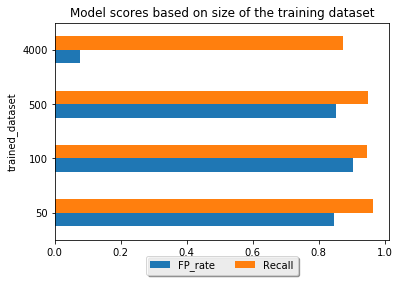

In [238]:
import pandas as pd
import matplotlib.pyplot as plt

df_fp_rate = pd.DataFrame([['FP_rate',4000,0.077],['FP_rate',500,0.854],['FP_rate',100,0.904],['FP_rate',50,0.846],
                   ['Recall',4000,0.875],['Recall',500,0.950],['Recall',100,0.947],['Recall',50,0.966]],
                    columns=['score','trained_dataset','val'])

df_fp_rate.pivot("trained_dataset", "score", "val").plot(kind='barh')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2)
plt.title('Model scores based on size of the training dataset')
plt.show()

# df_tn_fp = pd.DataFrame([['FP','4000',78],['FP','500',3876],['FP','100',4467],['FP','50',4223],
#                    ['TN','4000',930],['TN','500',678],['TN','100',470],['TN','50',768]],columns=['score','trained_dataset','val'])


# df_tn_fp.pivot("trained_dataset", "score", "val").plot(kind='bar')

# plt.show()





We added 15 positive cases to training, it causes that model label all data as positive. Now I try with stratified samples.

### Convnet

#### Training dataset size = 4000

In [243]:
x_train, x_val, y_train, y_val = split_data(0.2, 0)

print("x_train shape:", x_train.shape, ", x_val shape:", x_val.shape)
print("y_train shape:", y_train.shape, ", y_val shape:", y_val.shape)
print("included papers in train dataset:",(y_train[:,1]==1).sum())
print("included papers in test dataset:",(y_val[:,1]==1).sum())


x_train shape: (4061, 1000) , x_val shape: (1016, 1000)
y_train shape: (4061, 2) , y_val shape: (1016, 2)
included papers in train dataset: 32
included papers in test dataset: 8


In [ ]:
epochs = 10
BATCH_SIZE = 128
dropout=0.3
neurons=10
optimizer='rmsprop'

In [244]:
# convnet
print('convnet')
model = build_convnet()
(trained_model,loss, runtime) = train_model(model, epochs)
forward_pred = get_pred(trained_model)
print('loss:' ,loss,'runtime:', runtime.total_seconds())

convnet
loss: 0.0712402132024 runtime: 1279.113783


In [259]:
print(stats.describe(forward_pred[:,1]))
threshhold=0.00000001
(tn, fp, fn, tp) = get_scores_pred(forward_pred, threshhold)
cnn_score = (tn, fp, fn, tp)
print(cnn_score)
cnn_result = ('4000 papers',threshhold,tn, fp, fn, tp, loss, runtime.total_seconds())
print(cnn_result)

DescribeResult(nobs=1016, minmax=(1.4847232e-17, 0.0066562979), mean=1.7063758e-05, variance=7.9844718e-08, skewness=20.184995651245117, kurtosis=423.9775680582843)
(676, 332, 2, 6)
('4000 papers', 1e-08, 676, 332, 2, 6, 0.071240213202358224, 1279.113783)
